In [3]:
import sys
import os
# Get the directory path of the current script
current_script_directory = os.path.dirname(os.path.abspath(__file__))
# Construct the path to the src directory
src_directory = os.path.join(current_script_directory, "..", "src")
srcpro_directory = os.path.join(current_script_directory, "..", "src/propythia")

# Add the src directory to sys.path
sys.path.append(src_directory)
sys.path.append(srcpro_directory)

# Protein physicochemical descriptors and ML
This jupyter notebook will demonstrate how to obtain protein sequence-based features and their application to shalow machine learning models.

In [4]:
import pandas as pd
import numpy as np
from Bio import SeqIO

from propythia.protein.sequence import ReadSequence
from propythia.protein.descriptors import ProteinDescritors


# 1. Getting the data

First, lets get the data. 

We will use the Antimicrobial peptides case study using Veltri study.

The collection of data is available at
https://www.dveltri.com/ascan/v2/news.html

D. Veltri, U. Kamath, A. Shehu, Deep learning improves antimicrobial
peptide recognition, Bioinformatics 34 (16) (2018) 2740{2747. doi:10.1093/bioinformatics/bty179.e

In [7]:

amps_file = './AMP_Scan2_Feb2020_Dataset/AMPS_02182020.fasta'
non_amps_file = './AMP_Scan2_Feb2020_Dataset/DECOYS_02182020.fasta'


sequences = SeqIO.parse(amps_file, "fasta")
data = []

for record in sequences:
    data.append([record.id, str(record.seq), 1])

sequences = SeqIO.parse(non_amps_file, "fasta")
for record in sequences:
    data.append([record.id, str(record.seq), 0])

df = pd.DataFrame(data, columns=["ID", "sequence", 'label'])
print(df.head())

        ID                                          sequence  label
0  AP02484                             GMASKAGSVLGKITKIALGAL      1
1  AP02630       NIGLFTSTCFSSQCFSSKCFTDTCFSSNCFTGRHQCGYTHGSC      1
2  AP01427                    GAIKDALKGAAKTVAVELLKKAQCKLEKTC      1
3  AP02983                             FFGRLKAVFRGARQGWKEHRY      1
4  AP01815  DFGCARGMIFVCMRRCARMYPGSTGYCQGFRCMCDTMIPIRRPPFIMG      1


In [12]:
# Get the maximum and minimum length of strings in the specified column
max_length = df["sequence"].str.len().max()
min_length = df["sequence"].str.len().min()

print(f"Maximum length: {max_length}")
print(f"Minimum length: {min_length}")

Maximum length: 183
Minimum length: 11


The module ReadSequence contains functions built to preprocess the protein sequences, by replacing or remove certain amino acids. 

The function "par_preprocessing" was designed to deal with pandas dataframes (it is required to specify the atribute dataset and the column of protein sequences) while the function "get_preprocessing" was designed to process only one sequence.

The preprocessing phase may be required to calculate certain descriptors features or encodings.

In [8]:
read_seqs = ReadSequence()
res = read_seqs.par_preprocessing(dataset= df, col = 'sequence', B ='N', Z = 'Q', U = 'C', O = 'K', J = 'I', X = '')
res

,ID,sequence,label
0,AP02484,GMASKAGSVLGKITKIALGAL,1
1,AP02630,NIGLFTSTCFSSQCFSSKCFTDTCFSSNCFTGRHQCGYTHGSC,1
2,AP01427,GAIKDALKGAAKTVAVELLKKAQCKLEKTC,1
3,AP02983,FFGRLKAVFRGARQGWKEHRY,1
4,AP01815,DFGCARGMIFVCMRRCARMYPGSTGYCQGFRCMCDTMIPIRRPPFIMG,1
...,...,...,...
4037,UniRef50_C5DJ44,SSGNVNEVPKQNAKHPMDSCQNLEQSAGTTSAEKEAIRALESQSSG...,0
4038,UniRef50_Q9XUP3,ESCNFAVFWKLVKGAYKPTTNPNEPFKVPGEVPKMIKPMVGFEDAV...,0
4039,UniRef50_Q9Y573,VAALNDCIYSVGGWNETQDALHTVEKYSFEEEKWVEVASMKVPRAG...,0
4040,UniRef50_Q54H44,PHTHTQKEVITSSVD,0


# 2. Calculate descriptors

The module ProteinDescriptors is responsible to perform the calculation of various sequence-based descriptors.

The module accepts as dataset a pandas dataframe, list of sequences and a sequence (string) as dataset. The parameter col is the name of the column to store the sequences, or the column where the sequences are present (pandas dataframe).

In [9]:
descriptors_df = ProteinDescritors(dataset= df ,  col= 'sequence')
descriptors_df.dataset

,ID,sequence,label
0,AP02484,GMASKAGSVLGKITKIALGAL,1
1,AP02630,NIGLFTSTCFSSQCFSSKCFTDTCFSSNCFTGRHQCGYTHGSC,1
2,AP01427,GAIKDALKGAAKTVAVELLKKAQCKLEKTC,1
3,AP02983,FFGRLKAVFRGARQGWKEHRY,1
4,AP01815,DFGCARGMIFVCMRRCARMYPGSTGYCQGFRCMCDTMIPIRRPPFIMG,1
...,...,...,...
4037,UniRef50_C5DJ44,SSGNVNEVPKQNAKHPMDSCQNLEQSAGTTSAEKEAIRALESQSSG...,0
4038,UniRef50_Q9XUP3,ESCNFAVFWKLVKGAYKPTTNPNEPFKVPGEVPKMIKPMVGFEDAV...,0
4039,UniRef50_Q9Y573,VAALNDCIYSVGGWNETQDALHTVEKYSFEEEKWVEVASMKVPRAG...,0
4040,UniRef50_Q54H44,PHTHTQKEVITSSVD,0


To calculate a descriptor, one can be call a specific function as get_length, get_aa_comp, or others. It also can be called function to get all descriptors of a set of descriptors (for example, get all physico chemical descriptors).

For example: 
    descriptors_df.get_lenght(n_jobs=4)
    descriptors_df.get_aa_comp(n_jobs=4)
    descriptors_df.get_all_physicochemical(ph=7, amide=False, n_jobs=4)

To obtain a certain set of descriptors it can be used the function get_adaptable which calculates the descriptors present in the list_of_functions. The list in the example calculates all psycho chemical descriptors, AAC, DPC, PAAC, APAAC, CTD with the default parameters. All functions have assigned default parameters.

For example: 
    descriptors_df.get_adaptable([17, 18, 19, 22, 24, 30])


This may be checked in more detail in Quickstart from protein descriptors and encodings. 


Here we will calculate all physicochemical features. The function get_all which calculates all descriptors available in the ProPythia package. The function get all receives the parameters need for all of the functions. They are all set by default but one can change it. One to take into consideration, is that, some of the parameters should not be higher than the sequence length. In datasets were sequences have lengths superior to 40, this is not a porblem. however, if the dataset has some protein sequences with minor lengths that parameters need to be changed. 
This happens in this dataset, has the minimum length is 11. 

Tricomposition is also defined to Falase as default due to the high dimensional of the features generated. These features are usually very sparse ( counts for all possible trigrams). If you wish to calculate, set it as True. 


get_all(ph: float = 7, amide: bool = False, 
        lamda_paac: int = 10, # len limited
        weight_paac: float = 0.05, 
        lamda_apaac: int = 10, # len limited 
        weight_apaac: float = 0.05, 
        maxlag_socn: int = 45, # len limited
        maxlag_qso: int = 30, # len limited
        weight_qso: float = 0.1, window: int = 7,
        scalename: str = 'Eisenberg', scalename_arc: str = 'peparc', angle: int = 100, modality: str = 'max',
        prof_type: str = 'uH', tricomp: bool = False, n_jobs: int = 4):

In [32]:
df = descriptors_df.get_all(maxlag_socn =10, maxlag_qso = 10, n_jobs=4)

/home/martinha/propythia/propythia/src/propythia/protein/descriptors.py:794: FutureWarning: Passing 'suffixes' which cause duplicate columns {'double_x', 'single_x', 'hydrogen_x', 'tot_x'} in the result is deprecated and will raise a MergeError in a future version.
  self.result = self.result.merge(self.get_bond(n_jobs=n_jobs), how='left', on = self.col)
/home/martinha/propythia/propythia/src/propythia/protein/descriptors.py:795: FutureWarning: Passing 'suffixes' which cause duplicate columns {'MW_modlamp_x'} in the result is deprecated and will raise a MergeError in a future version.
  self.result = self.result.merge(self.get_mw(n_jobs=n_jobs), how='left', on = self.col)
/home/martinha/propythia/propythia/src/propythia/protein/descriptors.py:796: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Gravy_x'} in the result is deprecated and will raise a MergeError in a future version.
  self.result = self.result.merge(self.get_gravy(n_jobs=n_jobs), how='left', on = self.co

/home/martinha/propythia/propythia/src/propythia/protein/descriptors.py:812: FutureWarning: Passing 'suffixes' which cause duplicate columns {'MoranAuto_AvFlexibility7_x', 'MoranAuto_AvFlexibility25_x', 'MoranAuto_Polarizability10_x', 'MoranAuto_Steric12_x', 'MoranAuto_ResidueASA18_x', 'MoranAuto_FreeEnergy27_x', 'MoranAuto_ResidueVol20_x', 'MoranAuto_Polarizability17_x', 'MoranAuto_AvFlexibility1_x', 'MoranAuto_ResidueVol9_x', 'MoranAuto_FreeEnergy15_x', 'MoranAuto_ResidueVol17_x', 'MoranAuto_Steric26_x', 'MoranAuto_Mutability16_x', 'MoranAuto_Hydrophobicity27_x', 'MoranAuto_Steric16_x', 'MoranAuto_Mutability11_x', 'MoranAuto_Polarizability24_x', 'MoranAuto_AvFlexibility29_x', 'MoranAuto_Polarizability22_x', 'MoranAuto_Steric28_x', 'MoranAuto_Hydrophobicity16_x', 'MoranAuto_AvFlexibility14_x', 'MoranAuto_FreeEnergy11_x', 'MoranAuto_Hydrophobicity8_x', 'MoranAuto_ResidueVol21_x', 'MoranAuto_Polarizability15_x', 'MoranAuto_ResidueVol18_x', 'MoranAuto_Mutability7_x', 'MoranAuto_FreeEnerg

/home/martinha/propythia/propythia/src/propythia/protein/descriptors.py:815: FutureWarning: Passing 'suffixes' which cause duplicate columns {'_SolventAccessibilityD2001_x', '_HydrophobicityD2100_x', '_ChargeD1025_x', '_PolarityC1_x', '_PolarityD3001_x', '_ChargeT12_x', '_ChargeC1_x', '_SecondaryStrD2100_x', '_ChargeD3025_x', '_ChargeD3075_x', '_SolventAccessibilityC1_x', '_ChargeD2100_x', '_PolarizabilityD2100_x', '_PolarityD3075_x', '_HydrophobicityT12_x', '_ChargeD2075_x', '_PolarityD1100_x', '_PolarityD3100_x', '_NormalizedVDWVD3001_x', '_SolventAccessibilityT12_x', '_SolventAccessibilityC3_x', '_SolventAccessibilityD1025_x', '_NormalizedVDWVC2_x', '_SolventAccessibilityD2025_x', '_PolarizabilityD1025_x', '_PolarizabilityC3_x', '_SecondaryStrD1025_x', '_HydrophobicityD2050_x', '_SolventAccessibilityD3100_x', '_PolarityD3050_x', '_PolarizabilityC1_x', '_HydrophobicityD1100_x', '_HydrophobicityD2001_x', '_PolarizabilityD2025_x', '_PolarizabilityD1100_x', '_ChargeD3100_x', '_ChargeD30

/home/martinha/propythia/propythia/src/propythia/protein/descriptors.py:818: FutureWarning: Passing 'suffixes' which cause duplicate columns {'PAAC15_x', 'PAAC28_x', 'PAAC5_x', 'PAAC22_x', 'PAAC11_x', 'PAAC21_x', 'PAAC25_x', 'PAAC27_x', 'PAAC30_x', 'PAAC17_x', 'PAAC23_x', 'PAAC7_x', 'PAAC12_x', 'PAAC18_x', 'PAAC3_x', 'PAAC20_x', 'PAAC19_x', 'PAAC2_x', 'PAAC13_x', 'PAAC26_x', 'PAAC1_x', 'PAAC10_x', 'PAAC9_x', 'PAAC14_x', 'PAAC6_x', 'PAAC29_x', 'PAAC8_x', 'PAAC4_x', 'PAAC24_x', 'PAAC16_x'} in the result is deprecated and will raise a MergeError in a future version.
  self.result = self.result.merge(self.get_paac(lamda_paac, weight_paac, n_jobs=n_jobs), how='left',
/home/martinha/propythia/propythia/src/propythia/protein/descriptors.py:820: FutureWarning: Passing 'suffixes' which cause duplicate columns {'APAAC14_x', 'APAAC20_x', 'APAAC24_x', 'APAAC38_x', 'APAAC34_x', 'APAAC16_x', 'APAAC13_x', 'APAAC33_x', 'APAAC39_x', 'APAAC22_x', 'APAAC5_x', 'APAAC18_x', 'APAAC40_x', 'APAAC27_x', 'APAAC

# 3. Cleaning and scaling
Calculate all possible features generates a high dimensional matrix. Not all of these features are relevant and some of them, for example Dipeptide composition can also be very sparse. Because of that, is important to clean non relevant features deleting columns with very low variance or just with zeros. 

As the dataset represents different units scaling is very important. The scaling and further feature selection, should be performed in the train dataset separatelly from the test set to avoid leakage of features. 

In [33]:
df

,ID_x,sequence,label,length_x,charge_x,chargedensity_x,formulaC_x,formulaH_x,formulaN_x,formulaO_x,...,crosscorr_6,moment,global,profile_0,profile_1,arc_0,arc_1,arc_2,arc_3,arc_4
0,AP02484,GMASKAGSVLGKITKIALGAL,1,21.0,2.995,0.001508,88,160,24,25,...,-0.189413,0.665301,0.545714,0.004815,0.406640,160,60,40,0,0
1,AP02630,NIGLFTSTCFSSQCFSSKCFTDTCFSSNCFTGRHQCGYTHGSC,1,43.0,0.720,0.000153,196,281,53,67,...,0.098146,0.517722,0.557143,-0.001360,0.243252,40,120,40,20,0
2,AP01427,GAIKDALKGAAKTVAVELLKKAQCKLEKTC,1,30.0,3.863,0.001234,136,243,37,41,...,-0.374192,0.765559,0.604286,-0.009150,0.628470,120,140,40,20,0
3,AP02983,FFGRLKAVFRGARQGWKEHRY,1,21.0,5.095,0.001952,121,178,38,27,...,0.441667,0.914266,0.085714,0.008860,0.546441,140,100,100,20,0
4,AP01815,DFGCARGMIFVCMRRCARMYPGSTGYCQGFRCMCDTMIPIRRPPFIMG,1,48.0,4.590,0.000834,234,367,69,60,...,-0.099340,0.970399,0.821429,0.000335,0.423373,100,80,40,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,UniRef50_C5DJ44,SSGNVNEVPKQNAKHPMDSCQNLEQSAGTTSAEKEAIRALESQSSG...,0,86.0,-4.860,-0.000534,363,582,106,156,...,-0.093969,0.859572,0.260000,-0.001631,0.394664,80,260,20,40,40
4038,UniRef50_Q9XUP3,ESCNFAVFWKLVKGAYKPTTNPNEPFKVPGEVPKMIKPMVGFEDAV...,0,86.0,4.965,0.000521,433,681,109,121,...,-0.196758,0.887482,0.647143,0.000552,0.434838,160,140,40,40,100
4039,UniRef50_Q9Y573,VAALNDCIYSVGGWNETQDALHTVEKYSFEEEKWVEVASMKVPRAG...,0,53.0,-4.033,-0.000686,258,396,66,82,...,-0.119802,0.669459,0.761429,-0.000019,0.343672,120,140,60,60,20
4040,UniRef50_Q54H44,PHTHTQKEVITSSVD,0,15.0,-0.805,-0.000480,70,112,20,27,...,-0.208611,0.419458,0.350000,0.026060,0.145182,30,120,30,40,20


In [56]:
# Remove columns with all values being zero
df2 = df.loc[:, (df != 0).any()]

print(df2.shape)

(4042, 5848)


In [59]:
# remove columns that have the same values - uplicated columns
df2 = df2.loc[:, ~df2.T.duplicated(keep='first')]
print(df2.shape)

(4042, 1429)


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df2.drop(columns=['ID_x','sequence','label'])
y = df2['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
print('train_x', X_train.shape)
print('test_x', X_test.shape)


scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


train_x (2708, 1426)
test_x (1334, 1426)


# 3. Reduce dimensionality - feature selection

As we can see, the number of features is still very high. to avoid giving noise to the model we should perform feature selection. 

Several feature selection techniques can be easily applied, including the removin of columns with low variance, selection based on statiscal tests and selection based on ML models such as RF and SVC. Go to https://scikit-learn.org/stable/modules/feature_selection.html for more info. 


Here, we will apply a Univariate selection. We will select the highest scoring 50 percentage of features based on mutual info classif. Other techniques and other functions can be used. 

In [61]:
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2


transformer = GenericUnivariateSelect(mutual_info_classif, mode='percentile', param=50).fit(X_train, y_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(2708, 713)
(1334, 713)


In [62]:
# assess the selected features 

scores = transformer.scores_  # scores of features
p_values = transformer.pvalues_  # p features

# get columns selected
column_selected = transformer.get_support(indices=True)  # indexes of selected columns
column_selected_names = df2.columns[column_selected]

f_scores = pd.DataFrame(scores, index=X.columns,columns=['features_rank']).sort_values(by=['features_rank'], ascending=False)
print(f_scores[:20])


                                         features_rank
charge_x                                      0.305689
_ChargeC3_x                                   0.253333
IsoelectricPoint_x                            0.243409
_ChargeT23_x                                  0.233279
chargedensity_x                               0.217129
_ChargeD3100_x                                0.207249
E_x                                           0.188967
PAAC6_x                                       0.174820
_ChargeD3075_x                                0.174019
APAAC6_x                                      0.172673
Molar_extinction_coefficient_oxidized_x       0.172267
_ChargeD3025_x                                0.159651
_ChargeD3050_x                                0.158737
QSOSW6_x                                      0.155357
_ChargeD3001_x                                0.151575
_SolventAccessibilityC1_x                     0.142866
_SolventAccessibilityD1100_x                  0.131447
_PolarityC

We can see that the majorit of the features related in terms of correlation with labels are Charge related

# 4. Run ML models



We are now ready to try out using shallow ML models. 

These can be used using Propythia functions or you can use Scikit learn functions. Lets see both ways

# 5. Feature importance
One of the biggest advantage of using shallow ML models and physicochemical features is that the importance given to each feature can be assessed. In this way, one might shed a light on the reasons why the modle is performing well or not and check if the features are meaningfull. 


Lets try a RF model. In Propythia, and when using the train best model, a grid search parameter optimization will be run. If a  param grid is not given, a default one is used. 

In [74]:
from propythia.ml.shallow_ml import ShallowML
from sklearn.metrics import make_scorer, matthews_corrcoef

ml = ShallowML(x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test,
               report_name=None, columns_names= column_selected_names)

# TRAIN BEST MODEL
best_rf_model = ml.train_best_model(model = 'rf', scaler=None,
                                     score=make_scorer(matthews_corrcoef),
                                     cv=5, optType='gridSearch',
                                     param_grid=None,
                                     n_jobs=40, random_state=1, refit=True)

#SCORES
scores, report, cm, cm2 = ml.score_testset(classifier=best_rf_model)
print(report)
print(cm)
for key, value in scores.items():
    print(f"{key}: {value}")

performing gridSearch...
GridSearchCV took 17.62 seconds for 6 candidate parameter settings.
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf',
                                        RandomForestClassifier(random_state=1))]),
             n_jobs=40,
             param_grid=[{'clf__bootstrap': [True], 'clf__criterion': ['gini'],
                          'clf__max_features': ['sqrt', 'log2'],
                          'clf__n_estimators': [10, 100, 500]}],
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.816 (std: 0.012)
 Parameters: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_features': 'log2', 'clf__n_estimators': 500}
 

Model with rank: 2
 Mean validation score: 0.807 (std: 0.014)
 Parameters: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__n_estimators': 100}
 

Model with rank: 3
 Mean validation score: 0.806 

In [79]:
ml.features_importances_df(
    classifier=best_rf_model, 
    top_features=10)

,importance
_SecondaryStrT23_x,0.021480
sequence,0.019199
QSOSW3_x,0.018652
label,0.018103
_SecondaryStrC3_x,0.016557
...,...
FP_x,0.000036
MD_x,0.000036
NE_x,0.000035
WS_x,0.000035


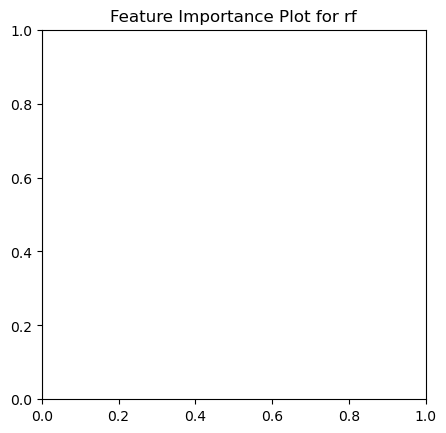

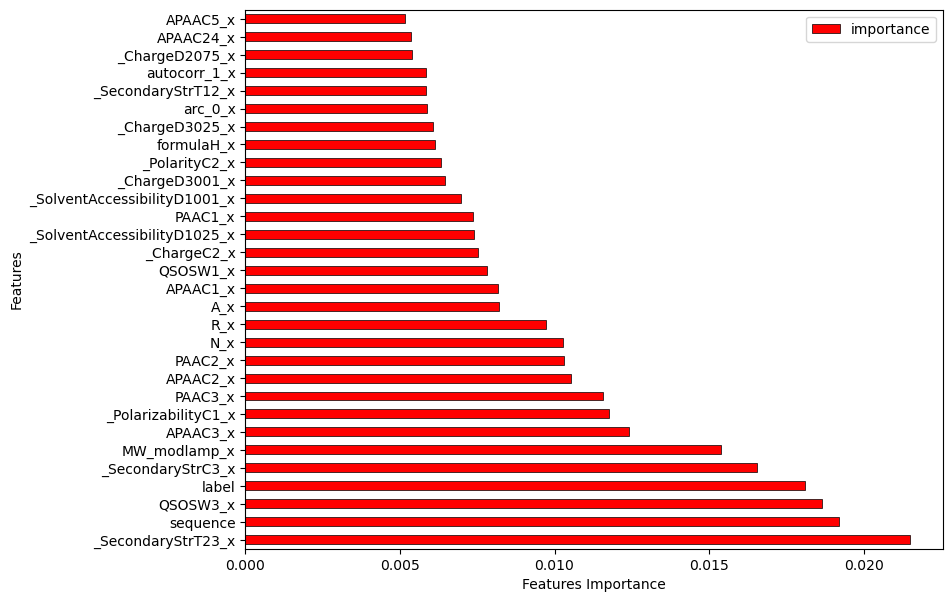

<Figure size 640x480 with 0 Axes>

In [80]:
ml.features_importances_plot(
    classifier=best_rf_model, 
    top_features=30, 
    model_name='rf',
    show=True, 
    path_save=None
)

lets try a SVC model with a defined paramgrid and a Logistic regression. 

In [81]:
# SVC
param_grid = {'clf__C': [0.1, 1.0, 10],
                        'clf__kernel': ['rbf', 'linear'],
                        'clf__gamma': [0.001,0.0001]}


ml = ShallowML(x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test,
               report_name=None, columns_names= column_selected_names)

# TRAIN BEST MODEL

# we will use as score the MCC
best_model = ml.train_best_model(model = 'svc', scaler=None,
                                     score=make_scorer(matthews_corrcoef),
                                     cv=5, optType='gridSearch',
                                     param_grid=param_grid,
                                     n_jobs=40, random_state=1, n_iter=15, refit=True)

scores, report, cm, cm2 = ml.score_testset(classifier=best_model)
print(report)
print(cm)
for key, value in scores.items():
    print(f"{key}: {value}")

performing gridSearch...
GridSearchCV took 27.34 seconds for 12 candidate parameter settings.
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf', SVC(random_state=1))]),
             n_jobs=40,
             param_grid={'clf__C': [0.1, 1.0, 10],
                         'clf__gamma': [0.001, 0.0001],
                         'clf__kernel': ['rbf', 'linear']},
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.828 (std: 0.027)
 Parameters: {'clf__C': 1.0, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
 

Model with rank: 2
 Mean validation score: 0.819 (std: 0.029)
 Parameters: {'clf__C': 10, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'}
 

Model with rank: 3
 Mean validation score: 0.815 (std: 0.039)
 Parameters: {'clf__C': 1.0, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'}
 

make_scorer(matthews_corrcoef)
5
Best score (scorer: make_scorer(matthews_corrcoef)) and parameters from a

The SVM feature importance can only be calculated if the best model has a linear kernel. 

Since the best model has the RBF kernel, we can't calculate the feature importance, so we will use the linear_svc model instead.

If a parameter grid is not defined for the train best model, a default one will be used

In [83]:
ml = ShallowML(x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test,
               report_name=None, columns_names= column_selected_names)

best_linear_svm_model = ml.train_best_model(
    model='linear_svc',                               
    score=make_scorer(matthews_corrcoef),
    param_grid=None
)

scores, report, cm, cm2 = ml.score_testset(best_linear_svm_model)
print(report)
print(cm)
for key, value in scores.items():
    print(f"{key}: {value}")

performing gridSearch...


/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mart

GridSearchCV took 8.76 seconds for 4 candidate parameter settings.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf', LinearSVC(random_state=1))]),
             n_jobs=5, param_grid=[{'clf__C': [0.01, 0.1, 1.0, 10]}],
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.779 (std: 0.041)
 Parameters: {'clf__C': 0.01}
 

Model with rank: 2
 Mean validation score: 0.719 (std: 0.043)
 Parameters: {'clf__C': 0.1}
 

Model with rank: 3
 Mean validation score: 0.679 (std: 0.052)
 Parameters: {'clf__C': 1.0}
 

make_scorer(matthews_corrcoef)
10
Best score (scorer: make_scorer(matthews_corrcoef)) and parameters from a 10-fold cross validation:
 MCC score:	0.779
 Parameters:	{'clf__C': 0.01}

0.778994 (0.041402) with: {'clf__C': 0.01}
0.719051 (0.043130) with: {'clf__C': 0.1}
0.678881 (0.052177) with: {'clf__C': 1.0}
0.672285 (0.051694) with: {'clf__C': 10}
   clf__C     means      

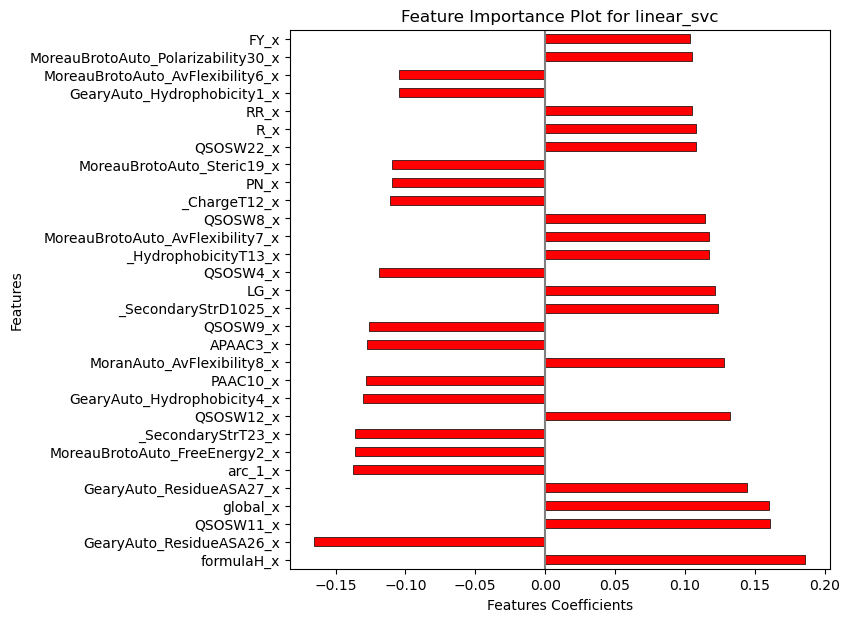

<Figure size 640x480 with 0 Axes>

In [84]:
ml.features_importances_plot(
    classifier=best_linear_svm_model, 
    model_name='linear_svc',
    column_to_plot=0,
    top_features=30, 
    show=True, 
    path_save=None
)

In [66]:
ml = ShallowML(x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test,
               report_name=None, columns_names= column_selected_names)

# we will use as score the MCC
best_model = ml.train_best_model(model = 'lr', scaler=None,
                                     score=make_scorer(matthews_corrcoef),
                                     cv=5, optType='gridSearch',
                                     param_grid=None,
                                     n_jobs=40, random_state=1, n_iter=15, refit=True)

scores, report, cm, cm2 = ml.score_testset(classifier=best_model)
print(report)
print(cm)
for key, value in scores.items():
    print(f"{key}: {value}")

performing gridSearch...


/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

GridSearchCV took 9.17 seconds for 12 candidate parameter settings.
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf',
                                        LogisticRegression(random_state=1))]),
             n_jobs=40,
             param_grid=[{'clf__C': [0.01, 0.1, 1.0, 10.0],
                          'clf__solver': ['liblinear', 'lbfgs', 'sag']}],
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.812 (std: 0.021)
 Parameters: {'clf__C': 0.01, 'clf__solver': 'sag'}
 

Model with rank: 2
 Mean validation score: 0.810 (std: 0.021)
 Parameters: {'clf__C': 0.01, 'clf__solver': 'liblinear'}
 

Model with rank: 3
 Mean validation score: 0.810 (std: 0.022)
 Parameters: {'clf__C': 0.01, 'clf__solver': 'lbfgs'}
 

make_scorer(matthews_corrcoef)
5
Best score (scorer: make_scorer(matthews_corrcoef)) and parameters from a 5-fold cross validation:
 MCC score:	0.812
 Parameters:	

RF and SVC perform similar. Logistic regression, achieve close results also. These models can also be further improved or other parameters tested. Other architectures such as GNB, KNN, gboosting, linear svc or others may also be tested for better results.

One can also use scikit learn (or any other library of interest) directly, instead of Propythia. 
Lets see how a SVC model performs.

In [68]:
from sklearn import svm
clf = svm.SVC(C=10,gamma=0.001,kernel='rbf')
best_model = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = matthews_corrcoef(y_test, y_pred)

print(score)

0.8096179504697988


# 6.  DL models with physicochemical features

Physico chemical features can also be given to DL models based on Dense networks. 

One just needs to define a DL model architecture and train. 

Besides that, adding callbacks such as early stopping and modelCheckpoint may be very beneficial.
In this notebook we will use the tensorflow library. 

We will focus on the use of the tensorfow library as example.An example to train with Propythia will also be made

In [85]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Conv1D,Conv2D, Flatten, MaxPool1D,MaxPool2D, Dropout, Input,GRU
from tensorflow.keras.layers import Embedding, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [87]:
model = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2,callbacks=[checkpoint, early_stopping])

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)

Epoch 1/100
34/34 [==============================] - 0s 4ms/step - loss: 0.5289 - accuracy: 0.7401 - val_loss: 0.2670 - val_accuracy: 0.8819
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 0.2525 - accuracy: 0.8999 - val_loss: 0.2455 - val_accuracy: 0.9022
Epoch 3/100
34/34 [==============================] - 0s 2ms/step - loss: 0.1546 - accuracy: 0.9432 - val_loss: 0.2397 - val_accuracy: 0.9077
Epoch 4/100
34/34 [==============================] - 0s 2ms/step - loss: 0.1153 - accuracy: 0.9614 - val_loss: 0.2476 - val_accuracy: 0.9133
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0800 - accuracy: 0.9751 - val_loss: 0.2712 - val_accuracy: 0.9170
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0604 - accuracy: 0.9809 - val_loss: 0.2932 - val_accuracy: 0.9151
Epoch 7/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0593 - accuracy: 0.9830 - val_loss: 0.3203 - val_accuracy: 0.9022
Epoch 8/100
3

In [88]:
print('===================================')
print("Mean Training Accuracy:", np.mean(history.history['accuracy']))
print("Mean Validation Accuracy:", np.mean(history.history['val_accuracy']))
print("Mean Training Loss:", np.mean(history.history['loss']))
print("Mean Validation Loss:", np.mean(history.history['val_loss']))

print('===================================')

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Mean Training Accuracy: 0.9773575870887093
Mean Validation Accuracy: 0.9048612325087838
Mean Training Loss: 0.0615190419813861
Mean Validation Loss: 0.4128464700087257
Test Loss: 0.2785
Test Accuracy: 0.8898


Using Propythia will be something like:

In [92]:
from propythia.ml.deep_ml import DeepML
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def model_dense():
    model = Sequential([
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model 




dl=DeepML(X_train, y_train, X_test, y_test, number_classes=2, problem_type='binary',
          x_dval=None, y_dval=None, epochs=100, batch_size=64,
          path='', report_name=None, verbose=1,
         early_stopping_patience=20, reduce_lr_patience=20, reduce_lr_factor=0.2, reduce_lr_min=0.00001,
                 )

model = KerasClassifier(build_fn=model_dense)

# run the model in Propythia
history = dl.run_model(model)

Epoch 1/100
39/39 [==============================] - 0s 3ms/step - loss: 0.5553 - accuracy: 0.7528 - val_loss: 0.2870 - val_accuracy: 0.8708

Epoch 00001: val_loss improved from inf to 0.28702, saving model to weights.hdf5
Epoch 2/100
39/39 [==============================] - 0s 2ms/step - loss: 0.2043 - accuracy: 0.9141 - val_loss: 0.2779 - val_accuracy: 0.8745

Epoch 00002: val_loss improved from 0.28702 to 0.27793, saving model to weights.hdf5
Epoch 3/100
39/39 [==============================] - 0s 2ms/step - loss: 0.1493 - accuracy: 0.9436 - val_loss: 0.2954 - val_accuracy: 0.8672

Epoch 00003: val_loss did not improve from 0.27793
Epoch 4/100
39/39 [==============================] - 0s 2ms/step - loss: 0.1197 - accuracy: 0.9567 - val_loss: 0.3097 - val_accuracy: 0.8893

Epoch 00004: val_loss did not improve from 0.27793
Epoch 5/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0825 - accuracy: 0.9704 - val_loss: 0.3346 - val_accuracy: 0.8782

Epoch 00005: val_loss 

<Figure size 640x480 with 0 Axes>

In [93]:
# evaluate on propythia
scores, report, cm, cm2 = dl.score_testset_classification()
scores

{'Accuracy': 0.8988005997001499,
 'MCC': 0.7976738180989609,
 'log_loss': 0.6409475094408597,
 'f1 score': 0.8994787788533135,
 'roc_auc': 0.8988005997001498,
 'Precision': array([0.5       , 0.89349112, 1.        ]),
 'Recall': array([1.        , 0.90554723, 0.        ]),
 'fdr': 0.10650887573964497,
 'sn': 0.9055472263868066,
 'sp': 0.8920539730134932}

The network tested as very simple. One can use hyper optimization algorithms to search for a better architecture. 

We reach the end of this tutorial. 